We have 9456 samples
[0 1 2 3 4 5]
Class 0 contains 461014 pixels
Class 1 contains 1289 pixels
Class 2 contains 2372 pixels
Class 3 contains 1695 pixels
Class 4 contains 3783 pixels
Class 5 contains 317 pixels
Accuracy is : 0.9550739957716702
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       261
           2       0.96      0.98      0.97       455
           3       0.92      0.91      0.92       360
           4       0.96      0.95      0.95       759
           5       0.94      0.89      0.92        57

   micro avg       0.96      0.96      0.96      1892
   macro avg       0.95      0.95      0.95      1892
weighted avg       0.96      0.96      0.95      1892



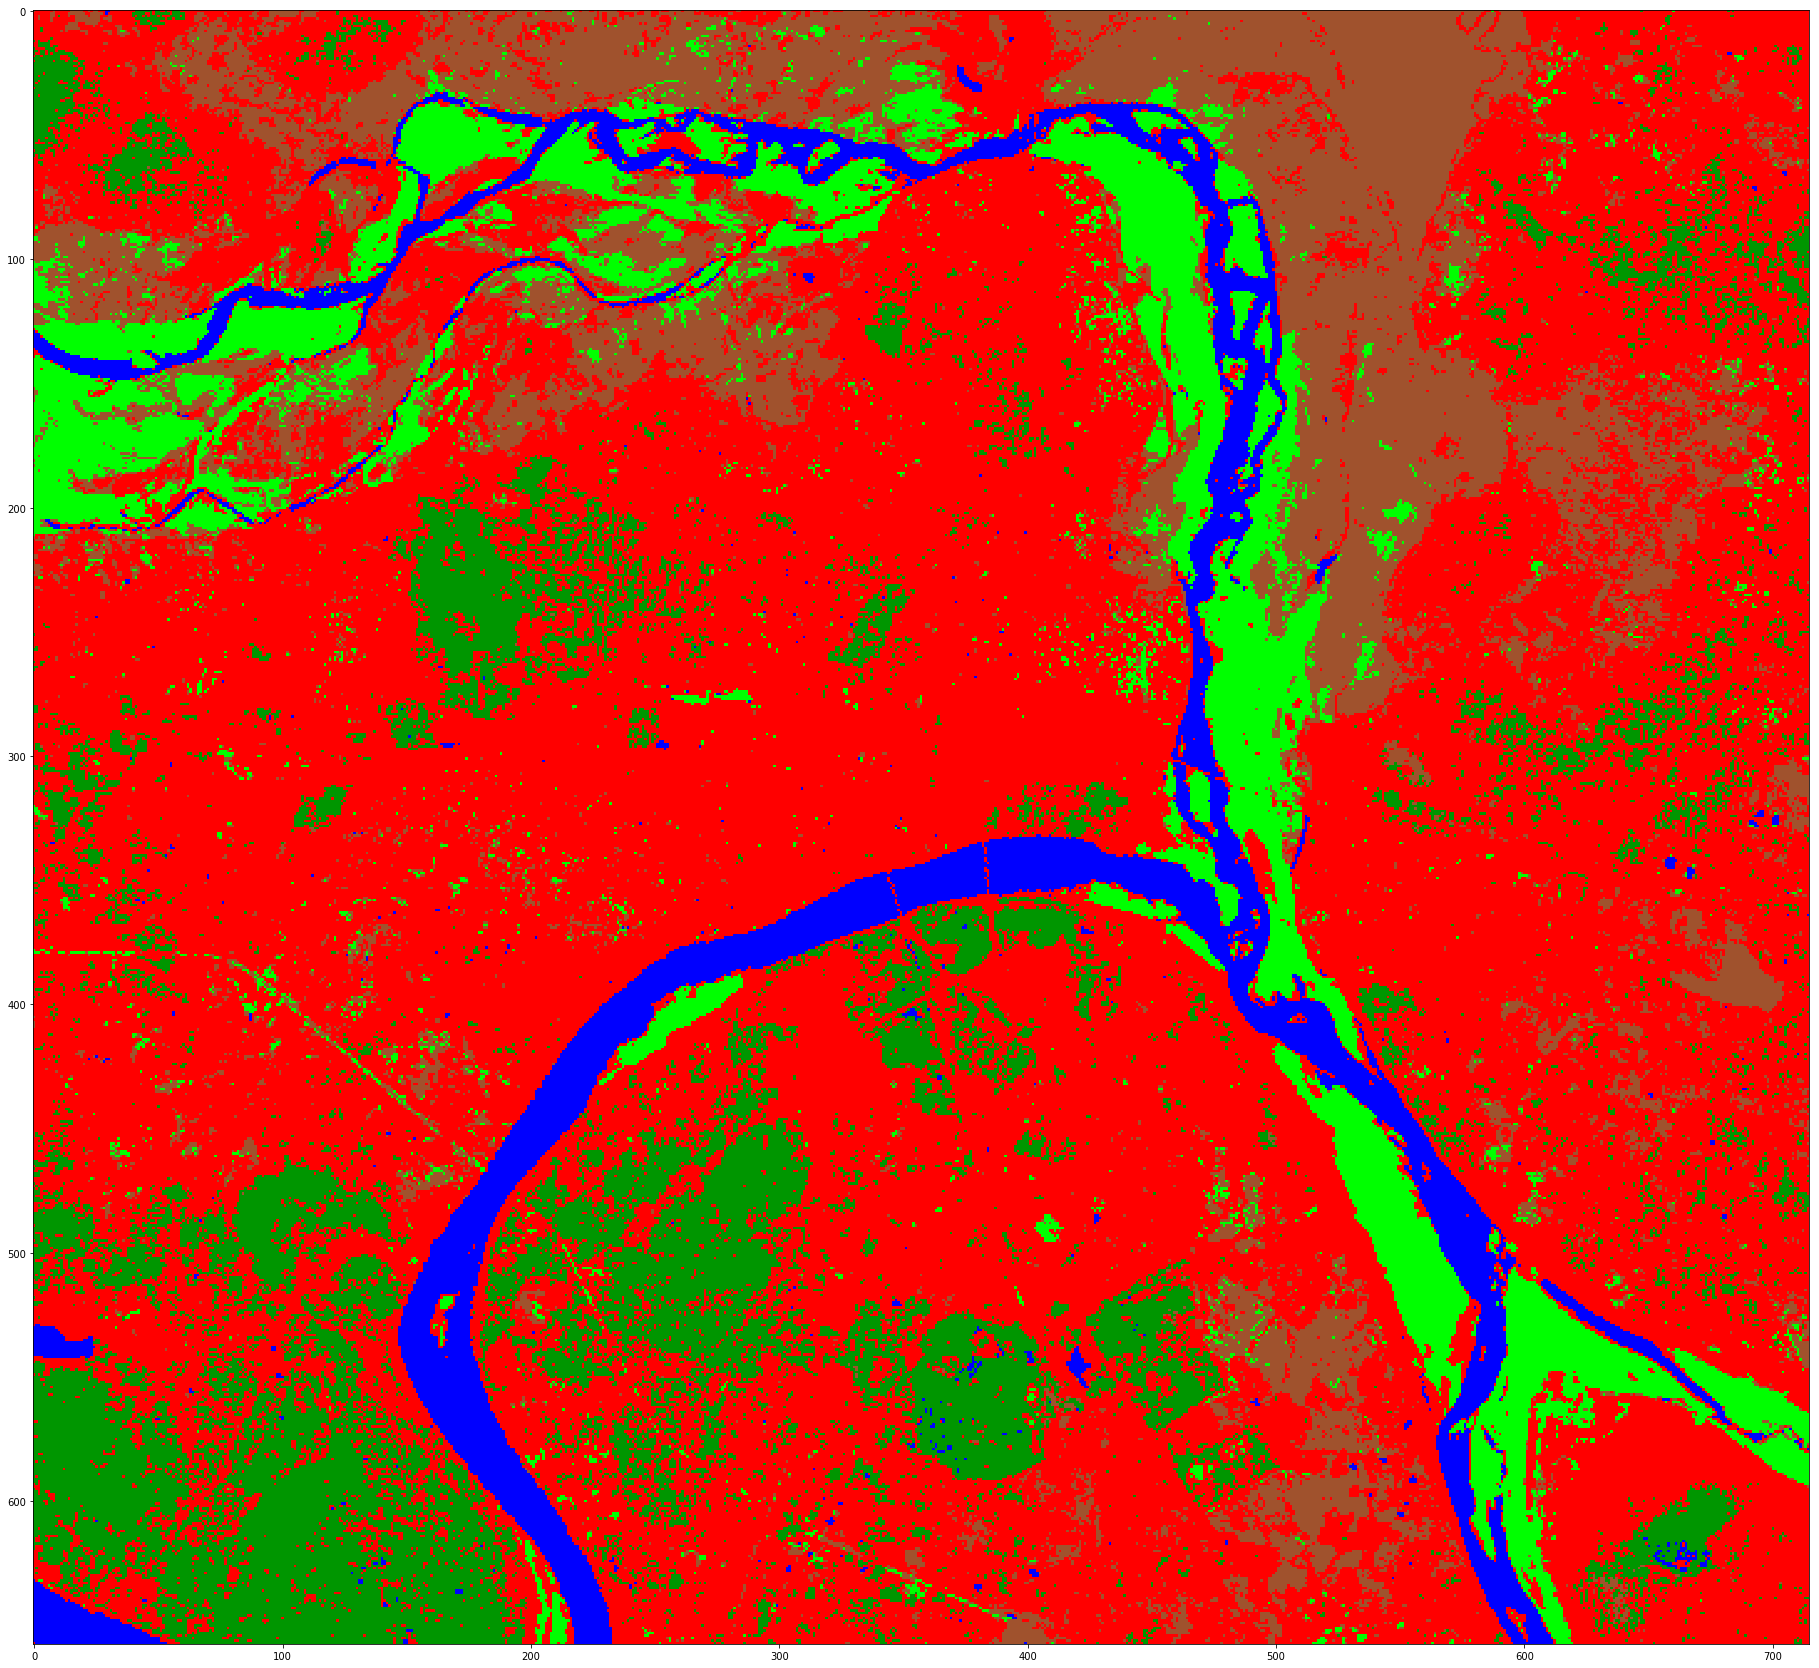

In [3]:
from osgeo import gdal
from osgeo import ogr
import sklearn
from sklearn import svm
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split  
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
ds=ogr.Open('training_svm1.shp')
lr=ds.GetLayerByIndex(0)

df=gdal.Open('2.tif')
row=df.RasterYSize
col=df.RasterXSize

proj=df.GetProjection()
ext=df.GetGeoTransform()

df=None

mem=gdal.GetDriverByName('GTiff')
out=mem.Create('training_svm.gtif',col,row,1,gdal.GDT_Byte)
out.SetProjection(proj)
out.SetGeoTransform(ext)


b=out.GetRasterBand(1)
b.Fill(0)

stat=gdal.RasterizeLayer(out,[1],lr,None,None,[0],['ALL_TOUCHED=TRUE','ATTRIBUTE=id'])

out=None


df=gdal.Open('training_svm.gtif',gdal.GA_ReadOnly) 
roi=df.GetRasterBand(1).ReadAsArray().astype('uint8')
#print(roi)
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

clas=np.unique(roi)
print(clas)
for c in clas:
    print('Class {c} contains {n} pixels'.format(c=c,n=(roi == c).sum()))

import numpy as np
ds=gdal.Open('stack.gtif')
arr=np.zeros((ds.RasterYSize,ds.RasterXSize,ds.RasterCount))
for i in range(arr.shape[2]):
    arr[:,:,i]=ds.GetRasterBand(i+1).ReadAsArray()


n_samples = (roi > 0).sum()

labels = np.unique(roi[roi > 0])

x = arr[roi > 0,:] 
y = roi[roi > 0]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20) 

model=svm.SVC(kernel="poly",degree=1,gamma='auto',C=1)
model.fit(x_train,y_train)
pred=model.predict(x_test)
acc = accuracy_score(y_test, pred)

print('Accuracy is :',acc)
print(classification_report(y_test, pred)) 
#print(arr.shape[0],arr.shape[2])

new_shape = (arr.shape[0] * arr.shape[1], arr.shape[2] )

img_as_array = arr[:, :, :6].reshape(new_shape)
class_prediction = model.predict(img_as_array)
class_prediction = class_prediction.reshape(arr[:, :, 0].shape)

n = class_prediction.max()

colors = dict((
    (0, (0, 0, 0, 255)),  # Nodata
    (5, (0, 150, 0, 255)),  # Forest
    (1, (0, 0, 255, 255)),  # Water
    (2, (0, 255, 0, 255)),  # sand
    (3, (160, 82, 45, 255)),  # Barren
    (4, (255, 0, 0, 255))  # Urban
))


for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

plt.figure(figsize=(70,70))
plt.subplot(122)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.show()